In [1]:
import sys, os, glob, datetime, cftime
import xarray as xr
import numpy as np
import pandas as pd
from scipy import float64
from dill.source import getsource

sys.path.append('../')

from _decomp import *
from _data_minimal import *
from _print_and_plot import *

%load_ext autoreload 
%autoreload 2

In [2]:
target_variable='TREFHT'
cov_variable = 'Z500'
months=[6,7,8]
period = [1850,2099]

In [3]:
runs = []
for run in [1300,1400,1500]:
    runs += [Struct(**dict(exp='CC', obj=decomp_CESM2_cc, run=run, color='darkorange'))]
    runs += [Struct(**dict(exp='piN', obj=decomp_CESM2_piN, run=run, color='darkcyan'))]
#runs += [Struct(**dict(exp='cc322', obj=decomp_CESM2_cc322, run=1300, color='m'))]
#runs += [Struct(**dict(exp='cc691', obj=decomp_CESM2_cc691, run=1300, color='r'))]
for run in runs:
    run.name = f"{run.exp} {run.run}"
for run in runs:
    run.lsty = {1300:'-', 1400:':', 1500:'-.'}[run.run]
runs = {run.name: run for run in runs}

In [4]:
for run_name,run in runs.items():
    run.obj = run.obj(run=run.run, target_variable=target_variable, months=months, period=period)
    run._x = {}

In [5]:
for run in runs.values():
    fls = run.obj.get_raw_file_names(var='TREFHT', time_freq='ann', additional_tag='_GL')
    run.gmt = xr.open_mfdataset(fls)['TREFHT'].squeeze().groupby('time.year').mean().loc[:2099]

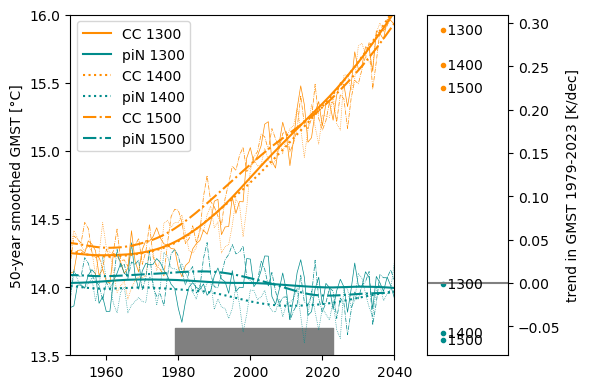

In [6]:
fig,axes = plt.subplots(ncols=2, figsize=(6,4), gridspec_kw=dict(width_ratios=[4,1]))

for run in runs.values():
    gmt = run.gmt - 273.15
    gmt_50 = lowess(gmt.values, gmt.year, frac=1/5, return_sorted=False)
    axes[0].plot(gmt.year, gmt, color=run.color, linestyle=run.lsty, linewidth=0.5)
    axes[0].plot(gmt.year, gmt_50, color=run.color, linestyle=run.lsty, label=run.name)
    y = gmt.loc[1979:2023]
    slope = sm.OLS(y.values, sm.add_constant(y.year.values)).fit().params[1] * 10
    axes[1].scatter(0, slope, color=run.color)
    axes[1].annotate(f" {run.name.split(' ')[1]}", xy=(0,slope), va='center')
ax = axes[0]
ax.set_xlim(1950,2040)
ax.set_ylim(13.5,16)
ax.legend()
ax.fill_between([1979,2023], [13.5,13.5], [13.7,13.7], color='gray')
ax.set_ylabel('50-year smoothed GMST [°C]')

ax = axes[1]
ax.axhline(0, color='gray')
ax.set_xlim(-0.1, 0.4)
ax.set_xticks([])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel('trend in GMST 1979-2023 [K/dec]')
plt.tight_layout()
savefig(f"GMT_ts_and_trends")

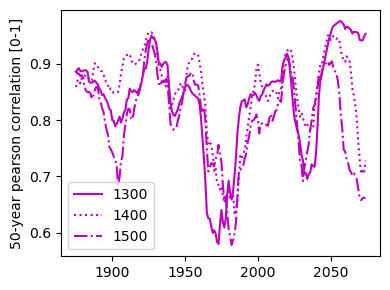

In [7]:
window = 50
years = np.arange(1875,2075,1,'int')
fig, ax = plt.subplots()
ax.set_ylabel('50-year pearson correlation [0-1]')
for run_number in [1300,1400,1500]:
    gmt_cc = runs[f"CC {run_number}"].gmt
    gmt_piN = runs[f"piN {run_number}"].gmt
    seasonal_corr = []
    for year in years:
        x = gmt_cc.loc[str(year-window/2):str(year+window/2)]
        y = gmt_piN.loc[str(year-window/2):str(year+window/2)]
        seasonal_corr.append(np.corrcoef(scipy.signal.detrend(y),scipy.signal.detrend(x))[0,1])
    ax.plot(years, seasonal_corr, color='m', linestyle=runs[f"CC {run_number}"].lsty, label=run_number)
ax.legend()
plt.tight_layout()
savefig(f"GMT_50year_corr")

## piControl trends

In [8]:
import warnings
warnings.filterwarnings("ignore")
tas = xr.open_mfdataset('/climca/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320/*.nc')['tas']

In [9]:
tmp_file = cdo.fldmean(
    input=f"-yearmean -mergetime /climca/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320/*.nc", 
    output=f"{cdo_tmp_dir}/CESM2_piControl_GMT.nc")

In [10]:
gmt_piControl = xr.open_dataset(tmp_file)['tas'].squeeze() - 273.15

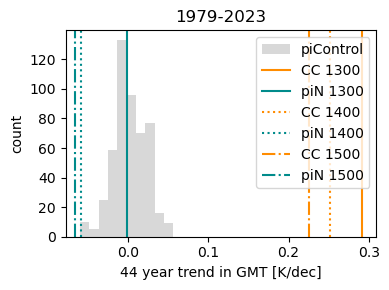

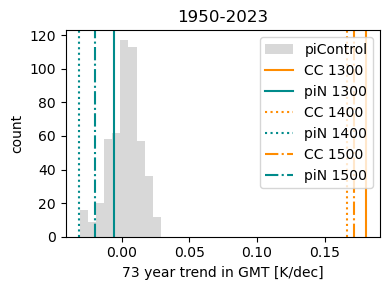

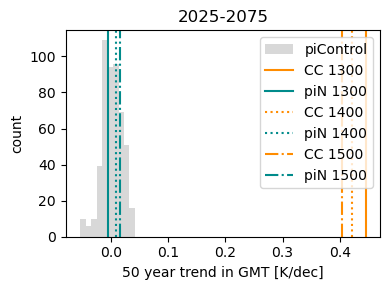

In [12]:
for period in [
    [1979,2023],
    [1950,2023],
    [2025,2075],
]:
    y1,y2 = period
    fig,ax = plt.subplots()
    window = y2-y1
    pi_slopes = []
    for i_year in range(1,501):
        y = gmt_piControl[-(window + i_year):-(i_year)]
        pi_slopes.append(sm.OLS(y.values, sm.add_constant(np.arange(0,len(y)))).fit().params[1])
    ax.hist(np.array(pi_slopes) * 10, color='gray', alpha=0.3, label='piControl', density=False)

    for run in runs.values():
        gmt = run.gmt - 273.15
        y = gmt.loc[y1:y2]
        slope = sm.OLS(y.values, sm.add_constant(y.year.values)).fit().params[1]
        ax.axvline(slope * 10, color=run.color, linestyle=run.lsty, label=run.name)
    ax.legend(loc='upper right')
    ax.set_title(f"{y1}-{y2}")
    ax.set_xlabel(f'{window} year trend in GMT [K/dec]')
    ax.set_ylabel('count')
    plt.tight_layout()
    savefig(f"GMT_trend_piC_{y1}-{y2}")

In [13]:
with xr.open_dataset('/climca/people/ppfleiderer/CESM_LE_GMT.nc') as nc:
    nc = nc.assign_coords(year=nc.time.dt.year)
    nc = nc.swap_dims({'time': 'year'})
    nc = nc.assign_coords(ens = nc.sfc.copy() * 0 + np.arange(1,101,1,'int'))
    nc = nc.swap_dims({'sfc': 'ens'})
    gmt_le = nc['TREFHT']


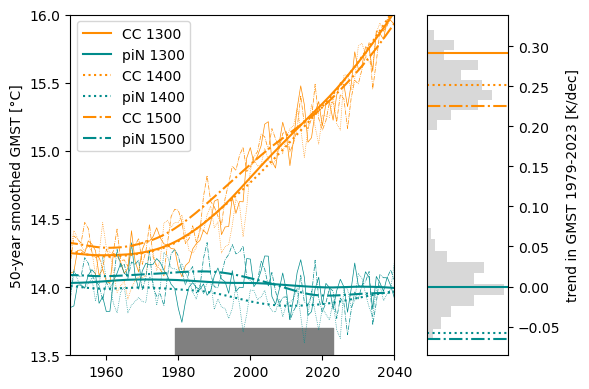

In [14]:
period = '1979-2023'
fig,axes = plt.subplots(ncols=2, figsize=(6,4), gridspec_kw=dict(width_ratios=[4,1]))

for run in runs.values():
    gmt = run.gmt - 273.15
    gmt_50 = lowess(gmt.values, gmt.year, frac=1/5, return_sorted=False)
    axes[0].plot(gmt.year, gmt, color=run.color, linestyle=run.lsty, linewidth=0.5)
    axes[0].plot(gmt.year, gmt_50, color=run.color, linestyle=run.lsty, label=run.name)
    y = gmt.loc[1979:2023]
    slope = sm.OLS(y.values, sm.add_constant(y.year.values)).fit().params[1] * 10
    axes[1].axhline(slope, color=run.color, linestyle=run.lsty)
    #$axes[1].annotate(f" {run.name.split(' ')[1]}", xy=(0,slope), va='center')
ax = axes[0]
ax.set_xlim(1950,2040)
ax.set_ylim(13.5,16)
ax.legend()
ax.fill_between([1979,2023], [13.5,13.5], [13.7,13.7], color='gray')
ax.set_ylabel('50-year smoothed GMST [°C]')

ax = axes[1]
pi_slopes = []
for i_year in range(1,1001):
    y = gmt_piControl[-(44 + i_year):-(i_year)]
    pi_slopes.append(sm.OLS(y.values, sm.add_constant(np.arange(0,len(y)))).fit().params[1])
ax.hist(np.array(pi_slopes) * 10, orientation='horizontal', color='gray', alpha=0.3, label='piControl', density=True)
y1,y2 = period.split('-')
LE_trends = gmt_le.loc[y1:y2].polyfit('year', deg=1)['polyfit_coefficients'][0].squeeze()
ax.hist(LE_trends * 10, orientation='horizontal', color='gray', alpha=0.3, label='hist', density=True)
#ax.axhline(0, color='gray')
#ax.set_xlim(-0.1, 0.4)
ax.set_xticks([])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel('trend in GMST 1979-2023 [K/dec]')
plt.tight_layout()
savefig(f"GMT_ts_and_trends_{period}")

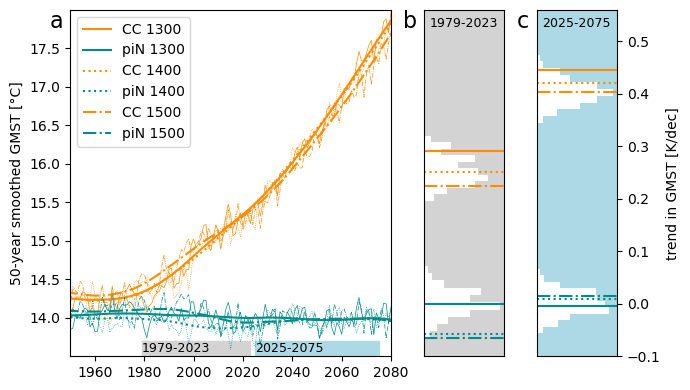

In [42]:
fig,axes = plt.subplots(ncols=3, figsize=(7,4), gridspec_kw=dict(width_ratios=[4,1,1]))

for run in runs.values():
    gmt = run.gmt - 273.15
    gmt_50 = lowess(gmt.values, gmt.year, frac=1/5, return_sorted=False)
    axes[0].plot(gmt.year, gmt, color=run.color, linestyle=run.lsty, linewidth=0.5)
    axes[0].plot(gmt.year, gmt_50, color=run.color, linestyle=run.lsty, label=run.name)
    for period,ax,n_years in zip(['1979-2023','2025-2075'], axes[1:], [44,50]):
        y1,y2 = [int(yr) for yr in period.split('-')]
        y = gmt.loc[y1:y2]
        slope = sm.OLS(y.values, sm.add_constant(y.year.values)).fit().params[1] * 10
        ax.axhline(slope, color=run.color, linestyle=run.lsty)
    #$axes[1].annotate(f" {run.name.split(' ')[1]}", xy=(0,slope), va='center')
ax = axes[0]
ax.set_xlim(1950,2080)
ax.set_ylim(13.5,18)
ax.legend()

ax.set_ylabel('50-year smoothed GMST [°C]')

for period,ax,n_years,color in zip(['1979-2023','2025-2075'], axes[1:], [44,50], ['lightgray','lightblue']):
    ax.set_facecolor(color)
    y1,y2 = period.split('-')
    axes[0].fill_between([int(y1),int(y2)], [13.5,13.5], [13.7,13.7], color=color)
    axes[0].annotate(period, xy=(int(y1), 13.55), fontsize=9)
    ax.annotate(period, xy=(0.5,0.98), xycoords='axes fraction', ha='center', va='top', fontsize=9)
    pi_slopes = []
    for i_year in range(1,1001):
        y = gmt_piControl[-(n_years + i_year):-(i_year)]
        pi_slopes.append(sm.OLS(y.values, sm.add_constant(np.arange(0,len(y)))).fit().params[1])
    ax.hist(np.array(pi_slopes) * 10, orientation='horizontal', color='w', label='piControl', density=True)
    LE_trends = gmt_le.loc[y1:y2].polyfit('year', deg=1)['polyfit_coefficients'][0].squeeze()
    ax.hist(LE_trends * 10, orientation='horizontal', color='w', label='hist', density=True)
    #ax.axhline(0, color='gray')
    ax.set_xticks([])
    ax.set_ylim(-0.1, 0.56)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
axes[0].set_yticks(np.arange(14,18,0.5))
axes[1].set_yticks([])
ax.set_ylabel('trend in GMST [K/dec]')
plt.tight_layout()
axes[0].text(0, 1, 'a ', transform=axes[0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right', clip_on=False)
axes[1].text(0, 1, 'b ', transform=axes[1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right', clip_on=False)
axes[2].text(0, 1, 'c ', transform=axes[2].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right', clip_on=False)
savefig(f"GMT_ts_and_trends")